<a href="https://colab.research.google.com/github/EricSiq/Understanding-DeepLearning/blob/main/Exp7_ChestXray_PneumoniaDetection_using_CNNs_withHyperparameterTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import core libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import os
import shutil


In [3]:

# Install Keras Tuner for hyperparameter tuning
!pip install -q keras-tuner

# Import Keras Tuner library
import keras_tuner as kt


In [4]:

# --- Data Download and Preparation ---
# This block automates downloading the dataset from Kaggle.
# It requires a 'kaggle.json' file with your API credentials.
try:
    # Attempt to install the Kaggle library
    !pip install -q kaggle

    # Check if kaggle.json is present
    if not os.path.exists('/root/.kaggle/kaggle.json'):
        print("Kaggle credentials not found. Please upload your kaggle.json file.")
        from google.colab import files
        files.upload() # This will prompt you to upload the file
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json

    # Download the dataset if it's not already downloaded
    dataset_name = 'paultimothymooney/chest-xray-pneumonia'
    zip_file = 'chest-xray-pneumonia.zip'
    dataset_dir = 'chest_xray'

    if not os.path.exists(dataset_dir):
        print(f"Downloading dataset: {dataset_name}...")
        !kaggle datasets download -d {dataset_name}
        print(f"Unzipping {zip_file}...")
        !unzip -q {zip_file}
        print("Dataset successfully downloaded and unzipped.")
    else:
        print("Dataset already exists. Skipping download.")

except Exception as e:
    print(f"An error occurred during data setup: {e}")


Dataset already exists. Skipping download.


In [5]:
# --- Define Data Generators with Augmentation ---
try:
    # Define paths to the dataset folders
    train_dir = os.path.join(dataset_dir, 'chest_xray', 'train')
    val_dir = os.path.join(dataset_dir, 'chest_xray', 'val')
    test_dir = os.path.join(dataset_dir, 'chest_xray', 'test')

    # Basic error check for folder existence
    if not all(os.path.exists(d) for d in [train_dir, val_dir, test_dir]):
        raise FileNotFoundError("Dataset directories not found. Please check paths.")

    # Data augmentation for the training set to prevent overfitting
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15, # Reduced range for faster augmentation
        zoom_range=0.1,    # Reduced range
        horizontal_flip=True,
    )

    # Only rescale validation and test data
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Use flow_from_directory to create generators
    IMG_SIZE = 150
    BATCH_SIZE = 32

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

except Exception as e:
    print(f"An error occurred during data preprocessing: {e}")



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:

# --- Define a Hypermodel Building Function with a smaller search space ---
def build_model(hp):
    """
    Builds a CNN model with a simplified, faster-to-tune hyperparameter search space.
    """
    model = Sequential()

    # We will only tune the number of filters and a single dense layer's units

    # Tunable number of filters for the first conv layer
    filters_1 = hp.Choice('filters_1', values=[32, 64])
    model.add(Conv2D(
        filters=filters_1,
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Tunable number of filters for the second conv layer
    filters_2 = hp.Choice('filters_2', values=[64, 128])
    model.add(Conv2D(
        filters=filters_2,
        kernel_size=(3, 3),
        activation='relu',
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output
    model.add(Flatten())

    # Tunable number of units for a single dense layer
    units = hp.Choice('units', values=[256, 512])
    model.add(Dense(units=units, activation='relu'))

    # Tunable dropout rate
    dropout_rate = hp.Choice('dropout', values=[0.3, 0.5])
    model.add(Dropout(rate=dropout_rate))

    # Final output layer
    model.add(Dense(1, activation='sigmoid'))

    # Tunable learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [1]:



# --- Instantiate and Run the Tuner with a small number of trials ---
try:
    tuner = kt.RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=5, # Limit to only 5 unique models
        executions_per_trial=1, # No need to run the same model multiple times
        directory='my_dir_simple',
        project_name='pneumonia_simple_tuning'
    )

    print("Starting hyperparameter search...")

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

    tuner.search(
        train_generator,
        epochs=5, # Significantly reduced number of epochs per trial
        validation_data=validation_generator,
        callbacks=[stop_early],
        steps_per_epoch=train_generator.samples // BATCH_SIZE
    )

    print("Hyperparameter search complete.")

    # Get the optimal hyperparameters and the best model
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]

    print("\n--- Best Hyperparameters Found ---")
    print(f"Optimal filters_1: {best_hps.get('filters_1')}")
    print(f"Optimal filters_2: {best_hps.get('filters_2')}")
    print(f"Optimal units: {best_hps.get('units')}")
    print(f"Optimal learning rate: {best_hps.get('learning_rate'):.5f}")

except Exception as e:
    print(f"An error occurred during hyperparameter tuning: {e}")

Trial 5 Complete [00h 21m 59s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.9375
Total elapsed time: 03h 49m 16s
Hyperparameter search complete.

--- Best Hyperparameters Found ---
Optimal filters_1: 32
Optimal filters_2: 128
Optimal units: 256
Optimal learning rate: 0.00100


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [7]:
# --- Retrieve and display the results summary ---
try:
    print("\n--- Hyperparameter Tuning Results Summary ---")
    tuner.results_summary()

    # You can also get a list of all trials
    trials = tuner.oracle.get_best_trials(num_trials=None)

except Exception as e:
    print(f"An error occurred while retrieving tuning results: {e}")


--- Hyperparameter Tuning Results Summary ---
Results summary
Results in my_dir_simple/pneumonia_simple_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
filters_1: 32
filters_2: 128
units: 256
dropout: 0.5
learning_rate: 0.001
Score: 0.9375

Trial 3 summary
Hyperparameters:
filters_1: 32
filters_2: 64
units: 512
dropout: 0.3
learning_rate: 0.001
Score: 0.8125

Trial 1 summary
Hyperparameters:
filters_1: 64
filters_2: 64
units: 512
dropout: 0.3
learning_rate: 0.001
Score: 0.75

Trial 0 summary
Hyperparameters:
filters_1: 64
filters_2: 64
units: 256
dropout: 0.5
learning_rate: 0.0001
Score: 0.6875

Trial 4 summary
Hyperparameters:
filters_1: 32
filters_2: 64
units: 256
dropout: 0.3
learning_rate: 0.0001
Score: 0.5
An error occurred while retrieving tuning results: '<' not supported between instances of 'int' and 'NoneType'



--- Visualizing Hyperparameter Performance ---


/tmp/ipython-input-307274109.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='filters_1', y='accuracy', data=df, ax=axes[0], palette='viridis')
/tmp/ipython-input-307274109.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='filters_2', y='accuracy', data=df, ax=axes[1], palette='plasma')
/tmp/ipython-input-307274109.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='units', y='accuracy', data=df, ax=axes[2], palette='magma')


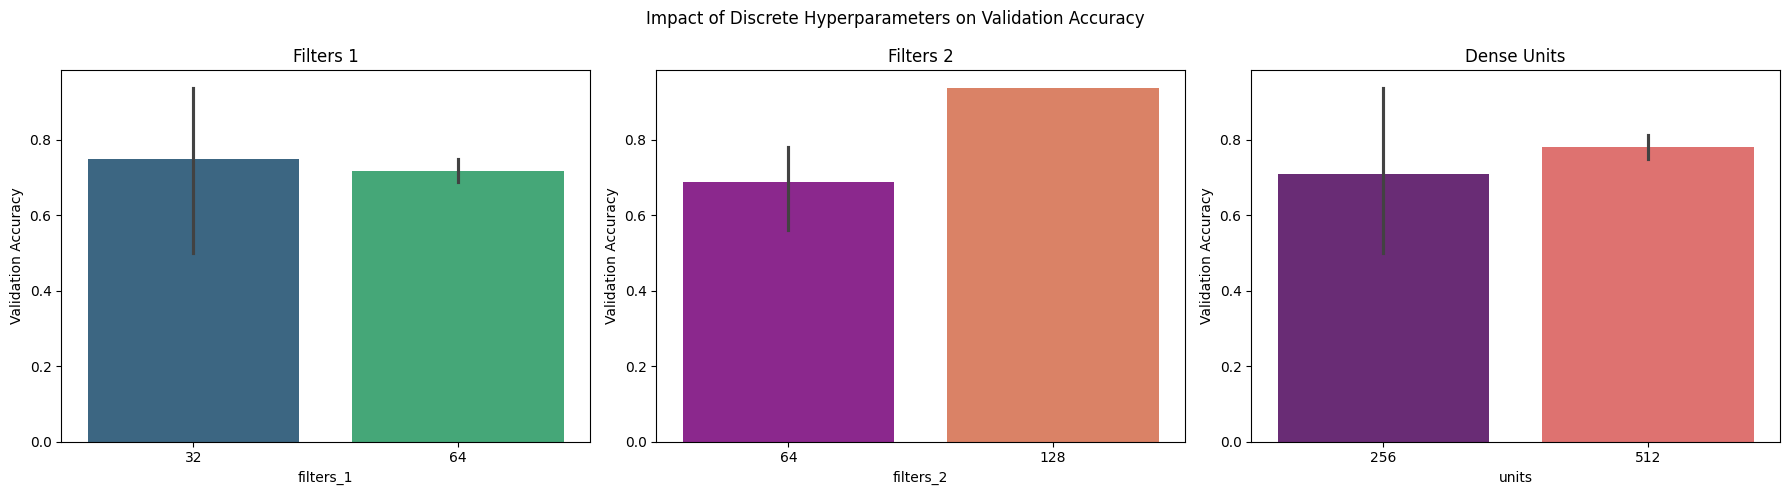

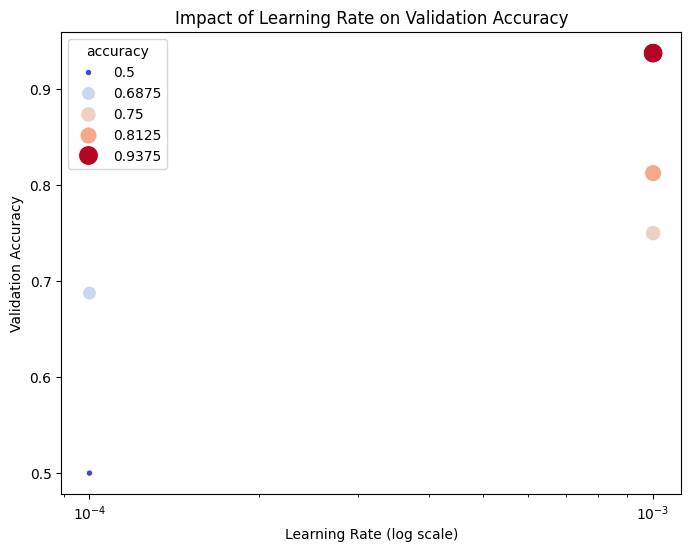

In [8]:
# --- Visualize the relationship between hyperparameters and performance ---
try:
    print("\n--- Visualizing Hyperparameter Performance ---")

    # Extract data from all trials
    all_trials = tuner.oracle.trials.values()

    # Check if there are trials to analyze
    if not all_trials:
        raise ValueError("No trials found to visualize. Please ensure tuning completed successfully.")

    data = []
    for trial in all_trials:
        if 'val_accuracy' in trial.metrics.metrics:
            trial_data = {
                'filters_1': trial.hyperparameters.get('filters_1'),
                'filters_2': trial.hyperparameters.get('filters_2'),
                'units': trial.hyperparameters.get('units'),
                'learning_rate': trial.hyperparameters.get('learning_rate'),
                'accuracy': trial.metrics.get_last_value('val_accuracy'),
            }
            data.append(trial_data)

    if not data:
        raise ValueError("No trial data with validation accuracy found. Check metrics.")

    import pandas as pd
    import seaborn as sns

    df = pd.DataFrame(data)

    # Plot 1: Bar plots for discrete hyperparameters
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Impact of Discrete Hyperparameters on Validation Accuracy')

    sns.barplot(x='filters_1', y='accuracy', data=df, ax=axes[0], palette='viridis')
    axes[0].set_title('Filters 1')
    axes[0].set_ylabel('Validation Accuracy')

    sns.barplot(x='filters_2', y='accuracy', data=df, ax=axes[1], palette='plasma')
    axes[1].set_title('Filters 2')
    axes[1].set_ylabel('Validation Accuracy')

    sns.barplot(x='units', y='accuracy', data=df, ax=axes[2], palette='magma')
    axes[2].set_title('Dense Units')
    axes[2].set_ylabel('Validation Accuracy')

    plt.tight_layout()
    plt.show()

    # Plot 2: Scatter plot for continuous hyperparameters (e.g., learning rate)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='learning_rate', y='accuracy', data=df, hue='accuracy', size='accuracy', palette='coolwarm', sizes=(20, 200))
    plt.xscale('log') # Use log scale for learning rate
    plt.title('Impact of Learning Rate on Validation Accuracy')
    plt.xlabel('Learning Rate (log scale)')
    plt.ylabel('Validation Accuracy')
    plt.show()

except Exception as e:
    print(f"An error occurred during plotting: {e}")